In [76]:
import matplotlib.pyplot as plt
import pandas 
import numpy
import re
import pickle
import backtest
import heapq

plt.rcParams.update({'font.size': 18})

# Individual Analysis

## Important Functions

In [132]:
def load_pkl_data(path_to_file):
  with open(path_to_file,"rb") as file:
    result = pickle.load(file, encoding='bytes')
    # print('read_goodlist:', result)
    return result

def save_as_pkl_data(result, path_to_file):
  with open(path_to_file,"wb") as file:
    pickle.dump(result, file)

def get_config_list(dataframe: pandas.DataFrame):
  config_list = dataframe[['config_length', 'config_multiplier']]
  return config_list.values.tolist()


class GoodList():
  '''
  Store configurations and its associated profit as heapq
  '''
  def __init__(self, max_length=10):
    self.toplist = []
    self.count = 0
    self.max_length = max_length

  def push(self, value, content):
    '''
    Replace configuration associating with the smallest profit/balance with a better one (if there's any) 
    '''
    if len(self.toplist) < self.max_length:
      heapq.heappush(self.toplist, (value, content))
    elif value > heapq.nsmallest(1, self.toplist)[0][0]:
      heapq.heapreplace(self.toplist, (value, content))


def get_top10_length_riskAdjusted(df):
    # Length
    goodlist_length = GoodList()
    for length in range(4,21):
        balance = list(df[df['config_length'].values == length]['balance'])

        # Calculate risk-adjusted return for
        median_return = numpy.median(balance)
        std = numpy.std(balance)
        sharpe_ratio = median_return/std

        goodlist_length.push(sharpe_ratio, length)

    return goodlist_length

def get_top10_multiplier_riskAdjusted(df):
    # Length
    goodlist_multiplier = GoodList()
    for multiplier in numpy.arange(4,20.5,0.5):
        balance = list(df[df['config_multiplier'].values == multiplier]['balance'])

        # Calculate risk-adjusted return 
        median_return = numpy.median(balance)
        std = numpy.std(balance)
        sharpe_ratio = median_return/std

        goodlist_multiplier.push(sharpe_ratio, multiplier)

    return goodlist_multiplier

def get_top_backtestProfit_with_these_configs(backtest_df: pandas.DataFrame, good_length: list, good_multiplier: list, output_path: str):
    '''
    Get top 10 config that has either length or multiplier in top(10) length and top(10) multiplier
    '''
    # if output_path == None: 
    #     output_path = f"backtest_summary/backtest_withBestConfig_{coin_timeframe}.csv"
    
    backtest_df.sort_values(by='balance', ascending=False, inplace=True)
    backtest_df = backtest_df[ backtest_df['config_length'].isin(good_length) & 
                               backtest_df['config_multiplier'].isin(good_multiplier)]
    backtest_df = backtest_df.iloc[:10,:]
    backtest_df.to_csv(output_path)
    return backtest_df
    

def save_good_configs(coin_timeframe, good_lengths, good_multipliers, good_config_pairs, filepath = './backtest_summary/good_configs.csv'):
    with open(filepath, "a") as file:
        file.write('{}, \"{}\", \"{}\", \"{}\"\n'.format(coin_timeframe, str(good_lengths)[1:-1], str(good_multipliers)[1:-1], str(good_config_pairs)))



def plot_balance_against_length_multiplier(df, coin_timeframe):
    df['balance_std'] = (df['balance'] - df['balance'].mean()) / df['balance'].std()

    # Plot balances distribution against Length and Multiplier 
    balance_for_lengths = []
    balance_for_multipliers = []
    
    # Length
    for length in range(4,21):
      balance_for_each_length = list(df[df['config_length'].values == length]['balance'])
      balance_for_lengths.append(balance_for_each_length)

    fig = plt.figure(figsize=[22, 6])
    ax = fig.add_subplot(1, 2, 1)
    ax.boxplot(balance_for_lengths);
    ax.set_xticklabels(range(4,21))
    ax.set_title('Balance vs. Length')

    # Multiplier
    for multiplier in numpy.arange(4,20.5,0.5):
      balance_for_each_multiplier = list(df[df['config_multiplier'].values == multiplier]['balance'])
      balance_for_multipliers.append(balance_for_each_multiplier)

    ax = fig.add_subplot(1, 2, 2)
    ax.boxplot(balance_for_multipliers);
    ax.set_xticklabels(numpy.arange(4,20.5,0.5))
    ax.set_title('Balance vs. Multiplier')

def plot_pnl_distribution_for_topConfigs(df, good_length, good_multiplier):
    '''
    Plot PnL histogram for TOP lengths and multipliers
    ''' 
    profit_amounts = []
    loss_amounts = []
    for multiplier in good_multiplier:
      for length in good_length:
        queried_df = df.copy().query(f"config_length=={length} & config_multiplier=={multiplier}")
        profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].profit_amounts).split(',')
        loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].loss_amounts).split(',')

    profit_amounts = [float(x) for x in profit_amounts]
    loss_amounts = [float(x) for x in loss_amounts]

    fig = plt.figure(figsize=[16, 9])
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(profit_amounts, 101);
    # ax.set_xticks(range(0,600,20))  #
    ax.set_title('Profits distribution of Top Lengths')

    ax = fig.add_subplot(2, 1, 2)
    ax.hist(loss_amounts, 101);
    # ax.set_xticks(range(0,600,20))
    ax.set_title('Losses distribution of Top Multipliers')

def plot_pnl_distribution_for_bestConfig(df, best_length, best_multiplier):
    '''
    Plot PnL histogram just for best length and multiplier
    '''

    print("Average profit and loss per trade of the best_length and best_multiplier")
    queried_df = df.query(f"config_length=={best_length} & config_multiplier=={best_multiplier}").copy()
    print(queried_df[['average_profit','average_loss']])

    # Convert strings to list
    profit_amounts = []
    loss_amounts = []
    
    # Regex operation is to remove punctuation marks and return a 'clean' string of numbers
    profit_amounts = profit_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].profit_amounts).split(',') 
    loss_amounts = loss_amounts + re.sub("\[|\]|\"|\s", "", queried_df.iloc[0].loss_amounts).split(',')

    # Convert int to float
    profit_amounts = [float(x) for x in profit_amounts]
    loss_amounts = [float(x) for x in loss_amounts]

    fig = plt.figure(figsize=[16, 9])
    ax = fig.add_subplot(2, 1, 1)
    ax.hist(profit_amounts, 101);
    # ax.set_xticks(range(0,600,20))  #
    ax.set_title('Profits distribution of The Best Length')

    ax = fig.add_subplot(2, 1, 2)
    ax.hist(loss_amounts, 101);
    # ax.set_xticks(range(0,600,20))
    ax.set_title('Losses distribution of The Best Multiplier')


## BTC 1h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


good_length:
[10, 11, 9, 17, 16, 18, 15, 14, 12, 13] 
good_multiplier:
[15.0, 16.0, 14.5, 17.0, 10.0, 16.5, 20.0, 19.0, 10.5, 19.5]
best_length: 15 
best_multiplier: 20.0
Average profit and loss per trade of the best_length and best_multiplier
     average_profit  average_loss
405       52.255505    -10.815636


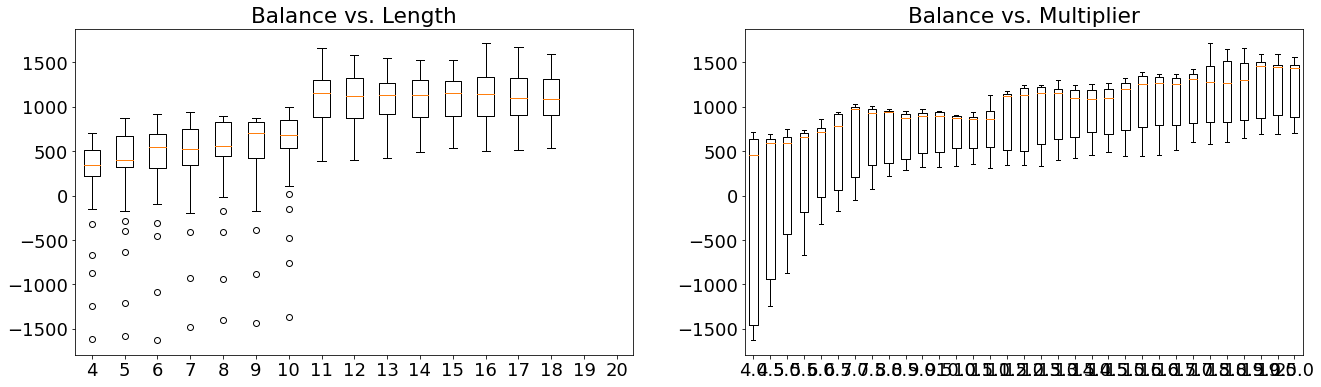

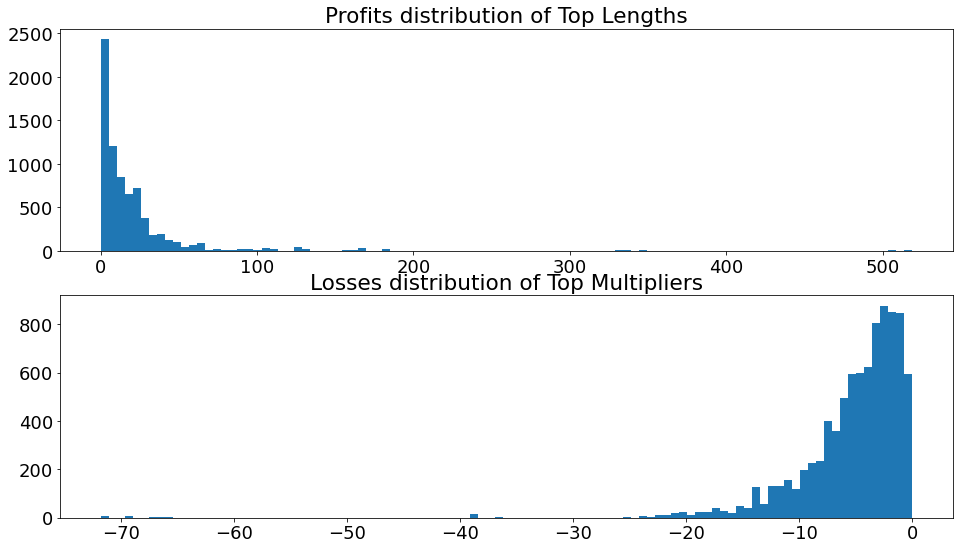

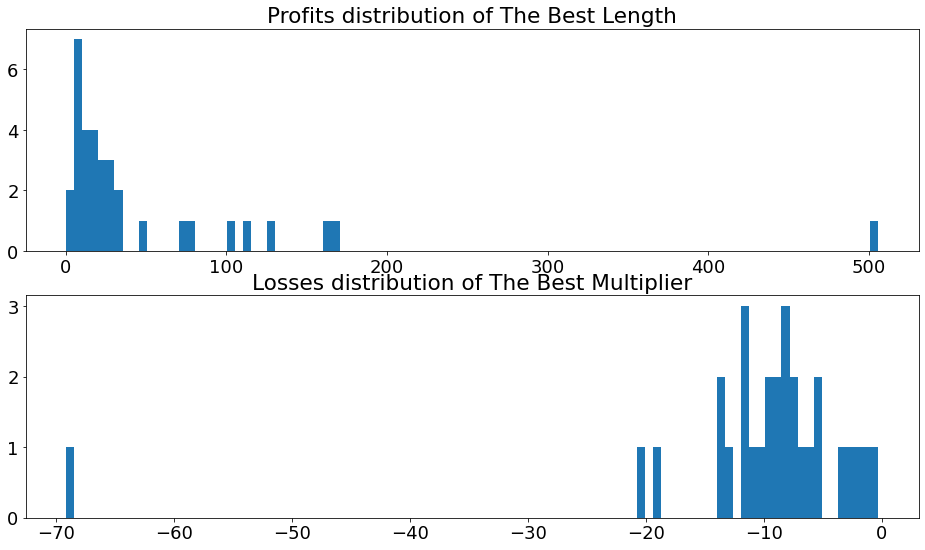

In [131]:
coin_timeframe = 'btc_1h'
df_btc1h = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")

top10_length = get_top10_length_riskAdjusted(df_btc1h).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(df_btc1h).toplist

good_length = [item[1] for item in top10_length]
good_multiplier = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'good_length:\n{good_length} ')
print(f'good_multiplier:\n{good_multiplier}')
print(f'best_length: {best_length} ')
print(f'best_multiplier: {best_multiplier}')

plot_balance_against_length_multiplier(df_btc1h, coin_timeframe)
plot_pnl_distribution_for_topConfigs(df_btc1h, top10_length, top10_multiplier)
plot_pnl_distribution_for_bestConfig(df_btc1h, best_length, best_multiplier)


backtest_df = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")
backtest_df = get_top_backtestProfit_with_these_configs(backtest_df, good_length, good_multiplier, f"backtest_summary/backtest_withBestConfig_{coin_timeframe}.csv")
good_config_pairs = get_config_list(backtest_df)

save_good_configs(coin_timeframe, good_length, good_multiplier, good_config_pairs, f"backtest_summary/good_configs.csv")

## BTC 4h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


good_length:
[11, 17, 9, 10, 18, 5, 6, 4, 7, 8] 
good_multiplier:
[12.0, 10.5, 11.0, 11.5, 10.0, 5.0, 9.5, 5.5, 9.0, 4.5]
best_length: 4 
best_multiplier: 5.0
Average profit and loss per trade of the best_length and best_multiplier
    average_profit  average_loss
43       29.751187     -6.240547


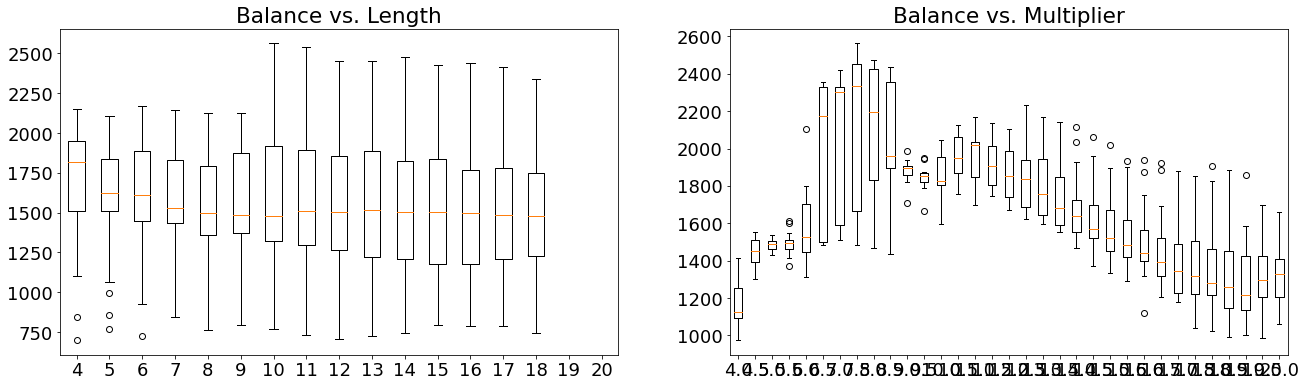

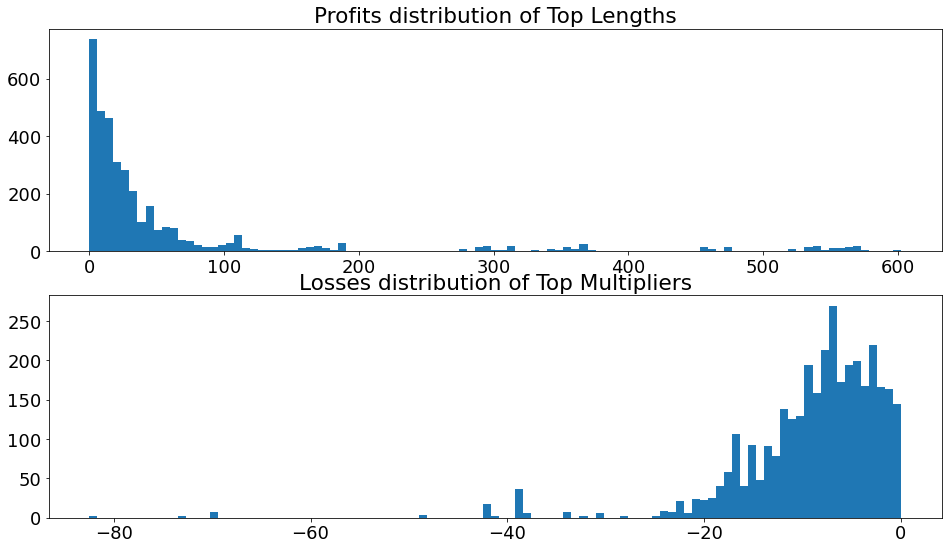

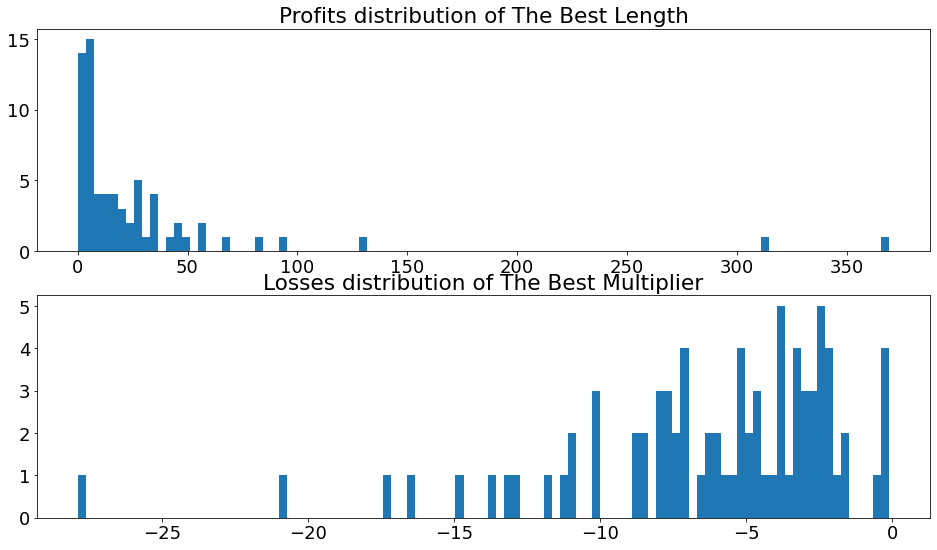

In [133]:
coin_timeframe = 'btc_4h'
df_btc4h = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")

top10_length = get_top10_length_riskAdjusted(df_btc4h).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(df_btc4h).toplist

good_length = [item[1] for item in top10_length]
good_multiplier = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'good_length:\n{good_length} ')
print(f'good_multiplier:\n{good_multiplier}')
print(f'best_length: {best_length} ')
print(f'best_multiplier: {best_multiplier}')

plot_balance_against_length_multiplier(df_btc4h, coin_timeframe)
plot_pnl_distribution_for_topConfigs(df_btc4h, top10_length, top10_multiplier)
plot_pnl_distribution_for_bestConfig(df_btc4h, best_length, best_multiplier)


backtest_df = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")
backtest_df = get_top_backtestProfit_with_these_configs(backtest_df, good_length, good_multiplier, f"backtest_summary/backtest_withBestConfig_{coin_timeframe}.csv")
good_config_pairs = get_config_list(backtest_df)

save_good_configs(coin_timeframe, good_length, good_multiplier, good_config_pairs, f"backtest_summary/good_configs.csv")


#### OLD VERSION

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


goodlist_length: [ 4.  5.  6.  7.  8.  9. 10. 11. 18. 17.]
goodlist_multiplier: [4.  4.5 5.  5.5 6.  9.  7.  7.5 8.  8.5]
kinda_best_length = 4;	kinda_best_multiplier = 5.0
    average_profit  average_loss
43       29.751187     -6.240547


{'coin_timeframe': 'btc_4h',
 'kinda_best_length': 4,
 'kinda_best_multiplier': 5.0,
 'good_length_list': array([ 4.,  5.,  6.,  7.,  8.,  9., 10., 11., 18., 17.]),
 'good_multiplier_list': array([4. , 4.5, 5. , 5.5, 6. , 9. , 7. , 7.5, 8. , 8.5])}

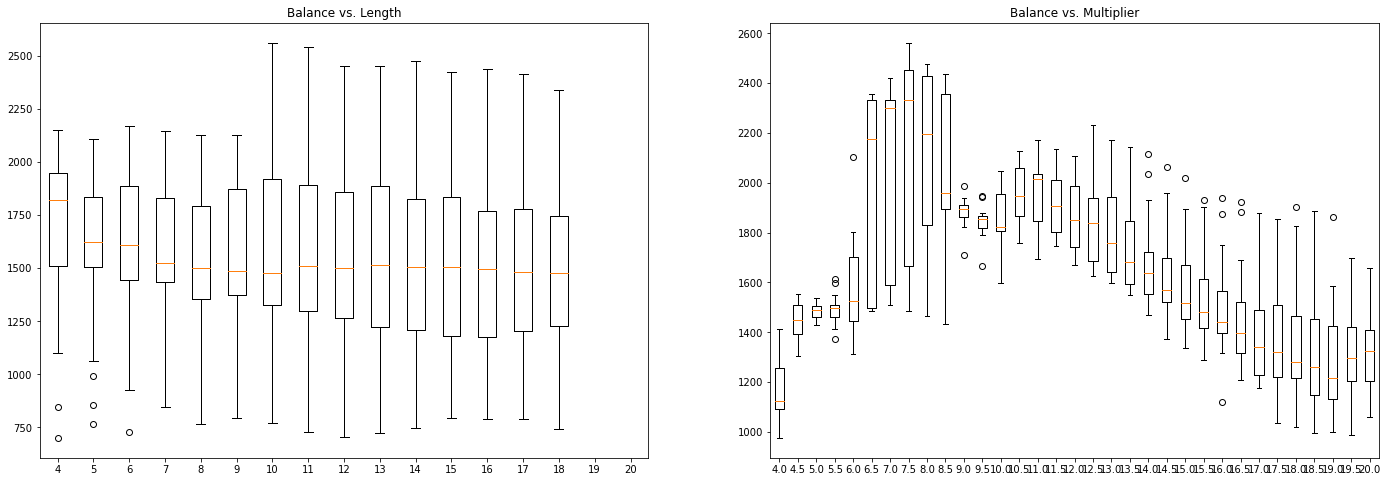

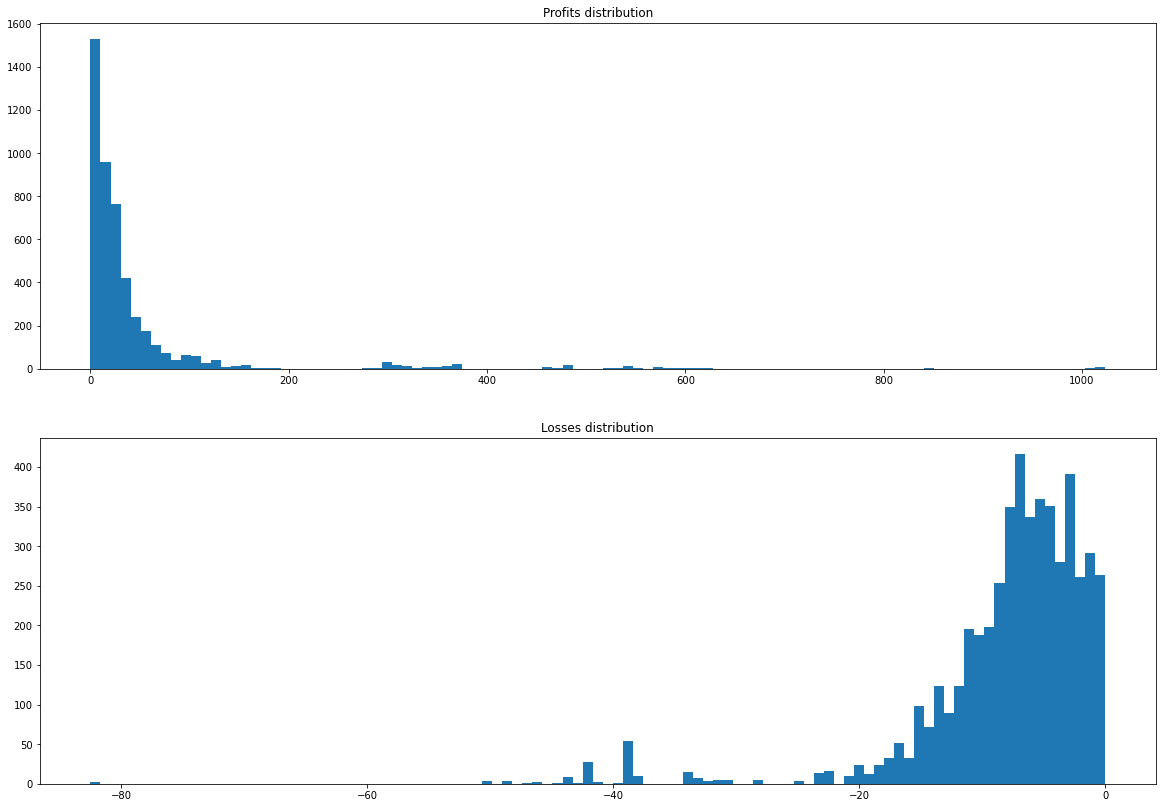

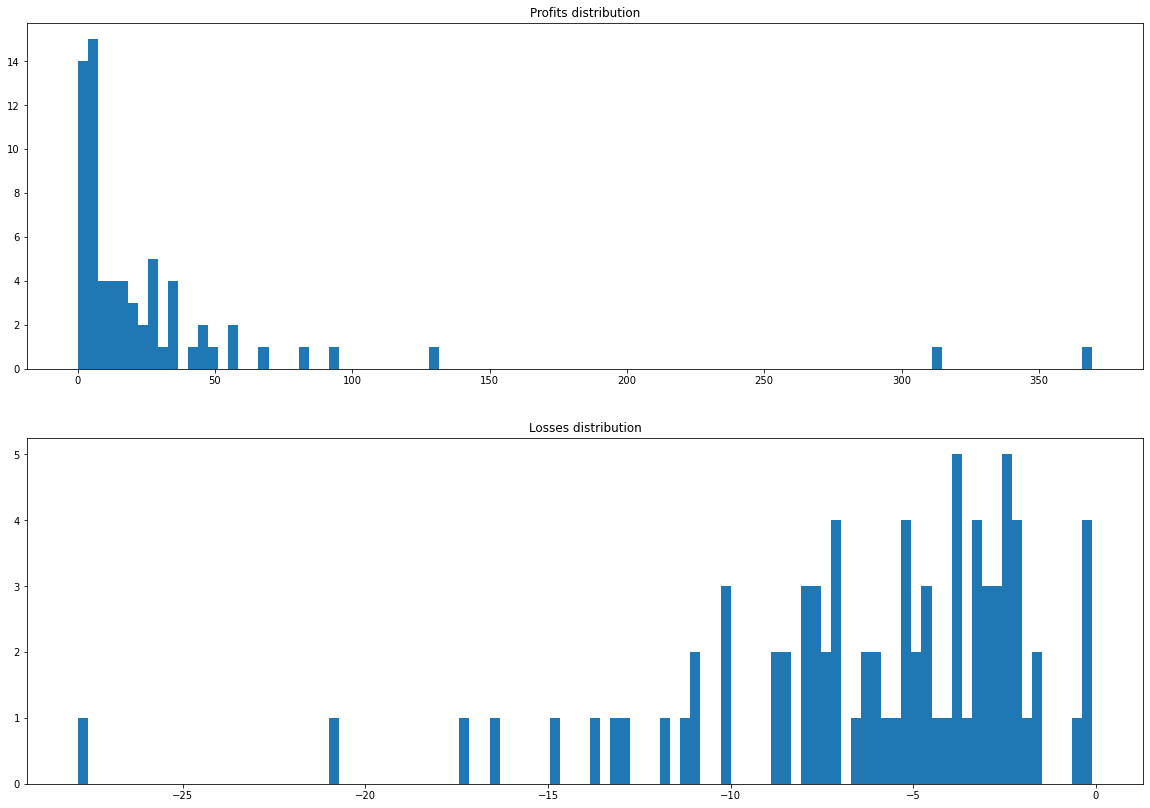

In [ ]:
# coin_timeframe = 'btc_4h'
# df_btc4h = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")
# result = plot1(df_btc4h, coin_timeframe)
# save_as_pkl_data(result, f"individual_backtest/goodlist_{coin_timeframe}.pkl")

## ETH 4h

/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rodo/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


good_length:
[7, 18, 9, 17, 13, 15, 10, 16, 12, 14] 
good_multiplier:
[18.0, 17.5, 11.0, 12.5, 17.0, 5.0, 11.5, 4.0, 12.0, 4.5]
best_length: 14 
best_multiplier: 5.0
Average profit and loss per trade of the best_length and best_multiplier
     average_profit  average_loss
389       32.876836     -9.727093


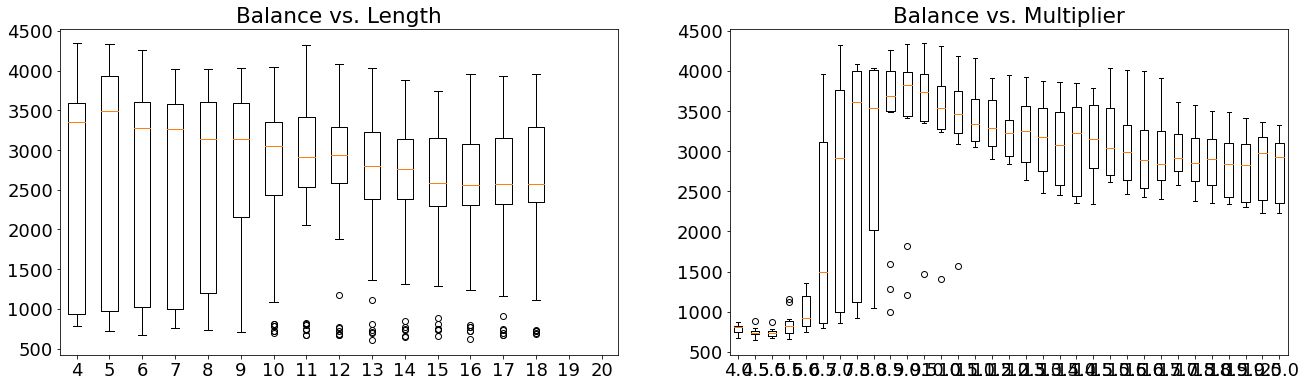

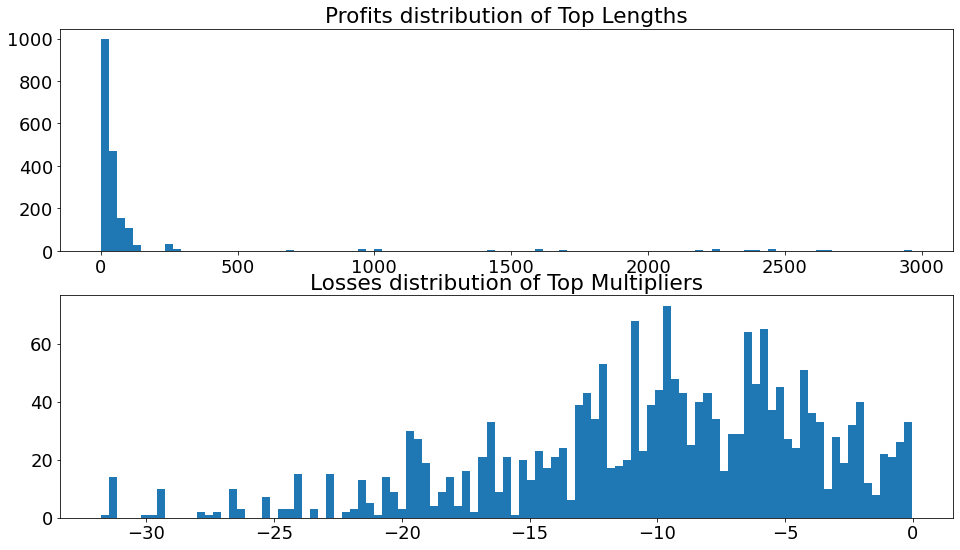

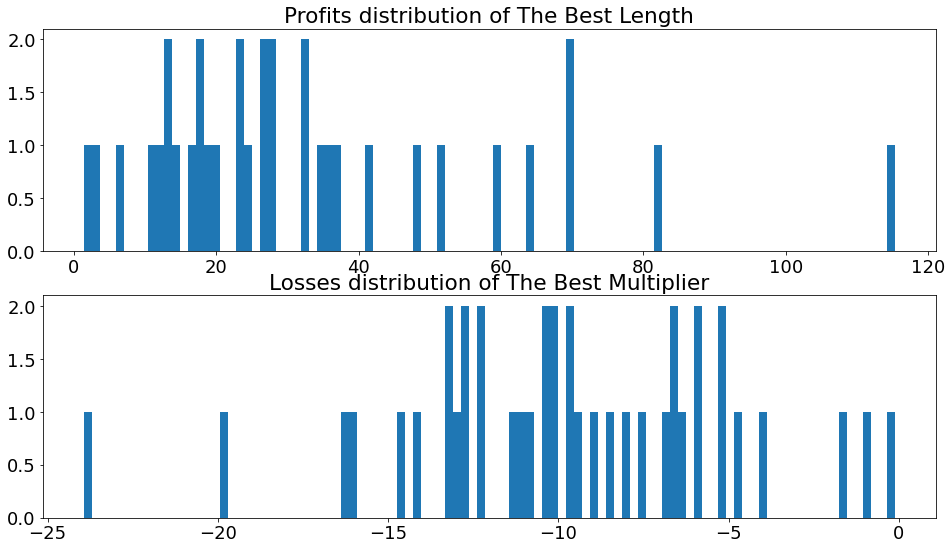

In [136]:
coin_timeframe = 'eth_4h'
df_eth4h = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")

top10_length = get_top10_length_riskAdjusted(df_eth4h).toplist
top10_multiplier = get_top10_multiplier_riskAdjusted(df_eth4h).toplist

good_length = [item[1] for item in top10_length]
good_multiplier = [item[1] for item in top10_multiplier]

best_length = heapq.nlargest(1, top10_length)[0][1]
best_multiplier = heapq.nlargest(1, top10_multiplier)[0][1]

print(f'good_length:\n{good_length} ')
print(f'good_multiplier:\n{good_multiplier}')
print(f'best_length: {best_length} ')
print(f'best_multiplier: {best_multiplier}')

plot_balance_against_length_multiplier(df_eth4h, coin_timeframe)
plot_pnl_distribution_for_topConfigs(df_eth4h, top10_length, top10_multiplier)
plot_pnl_distribution_for_bestConfig(df_eth4h, best_length, best_multiplier)


backtest_df = pandas.read_csv(f"individual_backtest/backtest_{coin_timeframe}.csv")
backtest_df = get_top_backtestProfit_with_these_configs(backtest_df, good_length, good_multiplier, f"backtest_summary/backtest_withBestConfig_{coin_timeframe}.csv")
good_config_pairs_eth4h = get_config_list(backtest_df)  # [[7.0, 11.0], [10.0, 11.0], [7.0, 11.5], [9.0, 11.0], [7.0, 12.5], [7.0, 12.0], [10.0, 11.5], [12.0, 11.0], [13.0, 11.0], [9.0, 11.5]]

save_good_configs(coin_timeframe, good_length, good_multiplier, good_config_pairs_eth4h, f"backtest_summary/good_configs.csv")

# Backtest again with good configs found on more recent data

In [141]:
import backtest

coins = ('eth', 'btc')
timeframes = ('4h',  '4h');  length_in_days = (1/6, 1/6)
trends = ('_recentYear', '_recentYear')  #'_bear1', '_bear2', '_bear3', 
config_lists = [  # copy from backtest_summary/good_configs.csv
    [[7.0, 11.0], [10.0, 11.0], [7.0, 11.5], [9.0, 11.0], [7.0, 12.5], [7.0, 12.0], [10.0, 11.5], [12.0, 11.0], [13.0, 11.0], [9.0, 11.5]], 
    [[6.0, 11.0], [7.0, 11.0], [6.0, 11.5], [8.0, 10.5], [5.0, 12.0], [10.0, 10.5], [7.0, 10.5], [4.0, 11.5], [11.0, 10.5], [6.0, 12.0]]
  ]
result_recorder = backtest.ResultRecorder()

for i in range(len(coins)):
  coin = coins[i]
  timeframe = timeframes[i]
  length_in_day = length_in_days[i]
  config_list = config_lists[i]

  print('timeframe =', timeframe)

  df = pandas.read_csv(f"historical_data/{coin}_{timeframe}_original{trend}.csv")
  # Rename columns and drop some to reduce memory weight
  df['timestamp'] = df['time_period_start']
  df['open'] = df['price_open']
  df['high'] = df['price_high']
  df['low'] = df['price_low']
  df['close'] = df['price_close']
  df.drop(['time_period_start', 'time_open', 
          'price_open', 'price_high', 'price_low', 
          'price_close', 'volume_traded', 'trades_count'], axis=1)
  df = df.iloc[::-1].reset_index()
  print('length_of_df =', len(df))

  for length, multiplier in config_list:
    length = int(length)
    print(f"config = ({length},{multiplier})")
    supertrend_data, balance = backtest.backtest(length, multiplier, result_recorder, df)
      
    result_recorder.add_new_row({
        'coinpair': coin,
        'timeframe': timeframe,
        'length_in_days': length_in_day*len(supertrend_data), 
        'trend': trend,
        'balance': balance, 
        'config_length': length, 
        'config_multiplier': multiplier, 
        'no_of_orders': result_recorder.order_number, 
        'number_of_profit_order': result_recorder.get_profit_order_number(), 
        'average_profit': result_recorder.get_average_profit(), 
        'number_of_loss_order': result_recorder.get_loss_order_number(), 
        'average_loss': result_recorder.get_average_loss(),
        'avarage_pnl_per_month': balance / (length_in_day*len(supertrend_data)) * 30,
        'profit_amounts': f"\"{result_recorder.get_profit_order()}\"",
        'loss_amounts': f"\"{result_recorder.get_loss_order()}\"",
    })
    result_recorder.reset_stats()

  result_recorder.save_in_csv(f"backtest_summary/backtest_withGoodConfigs.csv")
  print()


timeframe = 4h
length_of_df = 5706
config = (7,11.0)
config = (10,11.0)
config = (7,11.5)
config = (9,11.0)
config = (7,12.5)
config = (7,12.0)
config = (10,11.5)
config = (12,11.0)
config = (13,11.0)
config = (9,11.5)

timeframe = 4h
length_of_df = 5861
config = (6,11.0)
config = (7,11.0)
config = (6,11.5)
config = (8,10.5)
config = (5,12.0)
config = (10,10.5)
config = (7,10.5)
config = (4,11.5)
config = (11,10.5)
config = (6,12.0)

